# (Linear) Multivariate Analyses

Neural Data often comes from multiple sensors simulatenously, and often, these sensors might share information. Here we say that a source may be represented in multiple 'channels' (here in the abstract sense). To analyse such data from multiple sensors that relate to common sources together, one should employ multivariate analyses techniques if possible. To illustrate these perhaps abstract notions, we generate some simulated, but plausible 'neural' data.

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

import numpy as np

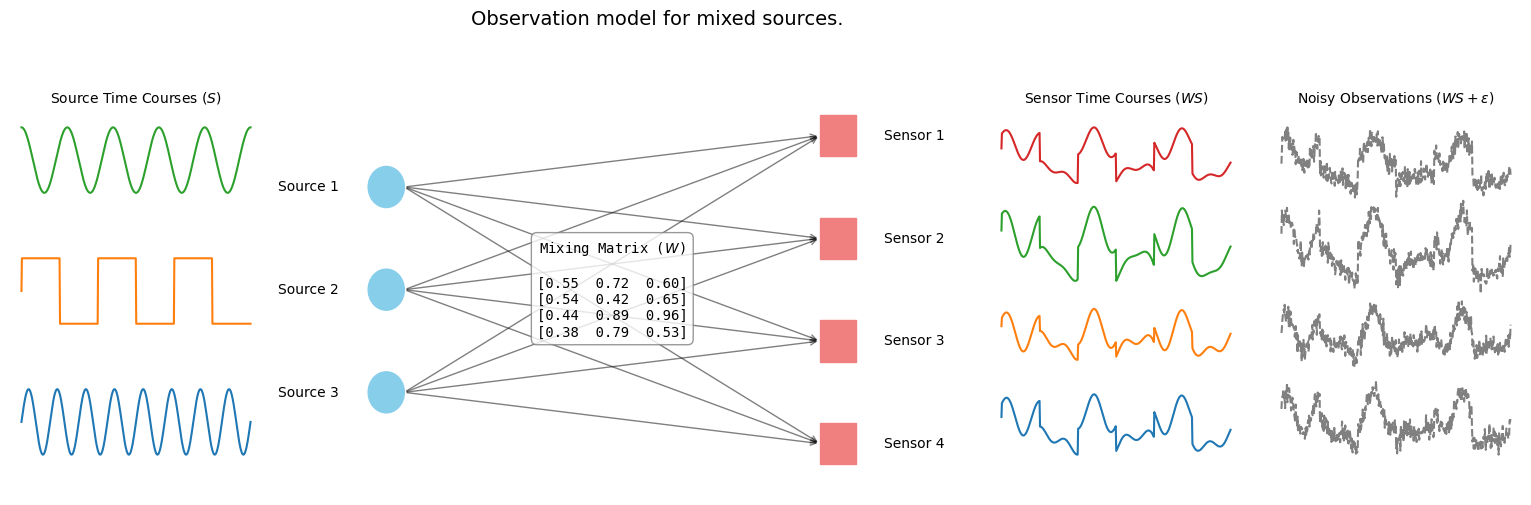

In [5]:
# Simulated source time courses
t = np.linspace(0, 1, 500)
s1 = np.sin(2 * np.pi * 8 * t)
s2 = np.sign(np.sin(2 * np.pi * 3 * t))
s3 = np.cos(2 * np.pi * 5 * t)
S = np.vstack([s1, s2, s3])

# Mixing matrix and mixed signals
np.random.seed(0)
mixing_matrix = np.random.rand(4, 3)
X = mixing_matrix @ S

# Add idiosyncratic white noise to each sensor signal
noise_level = 0.3
X_noisy = X + noise_level * np.random.randn(*X.shape)

# Source and sensor positions
sources = [(3, 4), (3, 3), (3, 2)]
sensors = [(8, 4.5), (8, 3.5), (8, 2.5), (8, 1.5)]

# Create main plot
fig, ax = plt.subplots(figsize=(14, 6))

# Draw sources
for i, (x, y) in enumerate(sources):
    ax.add_patch(patches.Circle((x, y), 0.2, color='skyblue'))
    ax.text(x - 1.2, y, f"Source {i+1}", verticalalignment='center')

# Draw sensors
for i, (x, y) in enumerate(sensors):
    ax.add_patch(patches.Rectangle((x - 0.2, y - 0.2), 0.4, 0.4, color='lightcoral'))
    ax.text(x + 0.5, y, f"Sensor {i+1}", verticalalignment='center')

# Draw arrows from each source to each sensor
for sx, sy in sources:
    for tx, ty in sensors:
        ax.annotate("",
                    xy=(tx - 0.2, ty),
                    xytext=(sx + 0.2, sy),
                    arrowprops=dict(arrowstyle="->", lw=1, alpha=0.5))

# Inset for source signals (left)
source_inset = fig.add_axes([0.05, 0.15, 0.18, 0.6])
for i in range(3):
    source_inset.plot(t, S[i] + i * 4, label=f"Source {i+1}")
source_inset.set_title("Source Time Courses ($S$)", fontsize=10)
source_inset.axis('off')

# Inset for sensor signals (middle right)
sensor_inset = fig.add_axes([0.75, 0.15, 0.18, 0.6])
for i in range(4):
    sensor_inset.plot(t, X[i] + i * 5, label=f"Sensor {i+1}")
sensor_inset.set_title("Sensor Time Courses ($WS$)", fontsize=10)
sensor_inset.axis('off')

# Inset for noisy sensor signals (far right)
noisy_inset = fig.add_axes([0.95, 0.15, 0.18, 0.6])
for i in range(4):
    noisy_inset.plot(t, X_noisy[i] + i * 5, label=f"Sensor {i+1} + noise", linestyle='--', color='gray')
noisy_inset.set_title("Noisy Observations ($WS + \\epsilon$)", fontsize=10)
noisy_inset.axis('off')

# Mixing matrix text box
matrix_str = '\n'.join(['[' + '  '.join(f"{val:.2f}" for val in row) + ']' for row in mixing_matrix])
ax.text(5.5, 3, f"Mixing Matrix ($W$)\n\n{matrix_str}", fontsize=10,
        bbox=dict(boxstyle="round,pad=0.4", edgecolor='gray', facecolor='white', alpha=0.8),
        ha='center', va='center', family='monospace')

# Final layout adjustments
ax.set_xlim(0, 12)
ax.set_ylim(1, 5.5)
ax.axis('off')
ax.set_title("Observation model for mixed sources.", fontsize=14)
plt.show()


## We Often Observe Mixtures of Sources

In neural data we most often do not directly observe the true sources of activity. Instead, we observe **mixtures** of those sources through sensors. This has several important implications:

1. **Our primary interest lies in the sources, not the sensors.**  
   The goal is typically to understand the underlying causes (e.g., activity in specific brain regions or individual neurons), rather than the raw sensor-level measurements.

2. **Analyzing sensors individually is often inefficient.**  
   Approaches like testing for significant effects in each channel separately (known as *mass-univariate analysis*) underutilizes the shared information between sensors and may miss important patterns, especially when those patterns are distributed across multiple sensors.

3. **We need to make assumptions to recover the sources.**  
   Since the true sources are not directly observable, but of interest for us, we must rely on specific assumptions about their statistical properties to estimate them. For most electrophysiological data, it is sensible to assume the mixing of sources into observed sensor signals as a linear combination, so that each sensor-signal is identifiable as a weighted sum of source activities. This linearity assumption makes everything much easier, and is reasonably justifiable.

   Mathematically, the recovery of source activity from observed sensor signals involves estimating an **unmixing matrix** \( W^{-1} \), which serves as the (pseudo-)inverse of the original mixing matrix \( W \). This transformation aims to approximate the original source signals from their observed mixtures. The estimate of the unmixing matrix depends crucially on our statistical assumptions, that our algorithm will try to optimize.




## Quantifying the structure of shared information between signals


At the core of all multivariate methods that we will discuss, lies the covariance matrix of the observed sensor-level data. The covariance matrix quantifies the linear dependency struct of the signals between all possible sensor pairs. We will plot the covariance matrix for a pair of sensors that capture shared sources.

To compute the covariance matrix from two signals $x$ and $y$, we use:

$$
\text{Cov}(x, y) = \frac{1}{N - 1} \sum_{i=1}^{N} (x_i - \bar{x})(y_i - \bar{y})
$$

where $\bar{x}$ and $\bar{y}$ are the means of the signals, and $N$ is the number of samples. One could also say that the covariance is the inner product of the mean centered variables, but that's very technical - yet useful in some applications.

In code, this can be computed using:

```python
import numpy as np

cov_matrix = np.cov(signal1, signal2)
```

This produces a 2×2 matrix where the diagonal elements are the variances of each signal, and the off-diagonal elements represent the covariance between them. A higher off-diagonal value indicates more shared structure—such as a common source—between the signals.

### Why Use $N - 1$ Instead of $N$?

When computing the covariance from sample data, we divide by $N - 1$ instead of $N$ to apply **Bessel’s correction**. This correction makes the estimate **unbiased**, meaning it more accurately reflects the true population covariance on average.

* **Sample covariance** (what we usually compute):

  $$
  \text{Cov}_{\text{sample}} = \frac{1}{N - 1} \sum (x_i - \bar{x})(y_i - \bar{y})
  $$

* **Population covariance** (if you had access to the entire population):

  $$
  \text{Cov}_{\text{population}} = \frac{1}{N} \sum (x_i - \mu_x)(y_i - \mu_y)
  $$

In practice, we rarely know the true population, so we work with samples—hence the use of $N - 1$. Functions like `np.cov` follow this convention by default. There, using ```np.cov(x,y, bias = True)``` will implement division by N.

### Demonstration of Covariance between two Channels

In the following, you will see two channels that both partially carry a 10Hz oscillation, as well as some noise. In the covariance structure, you see that it has an elongated, elliptical shape.


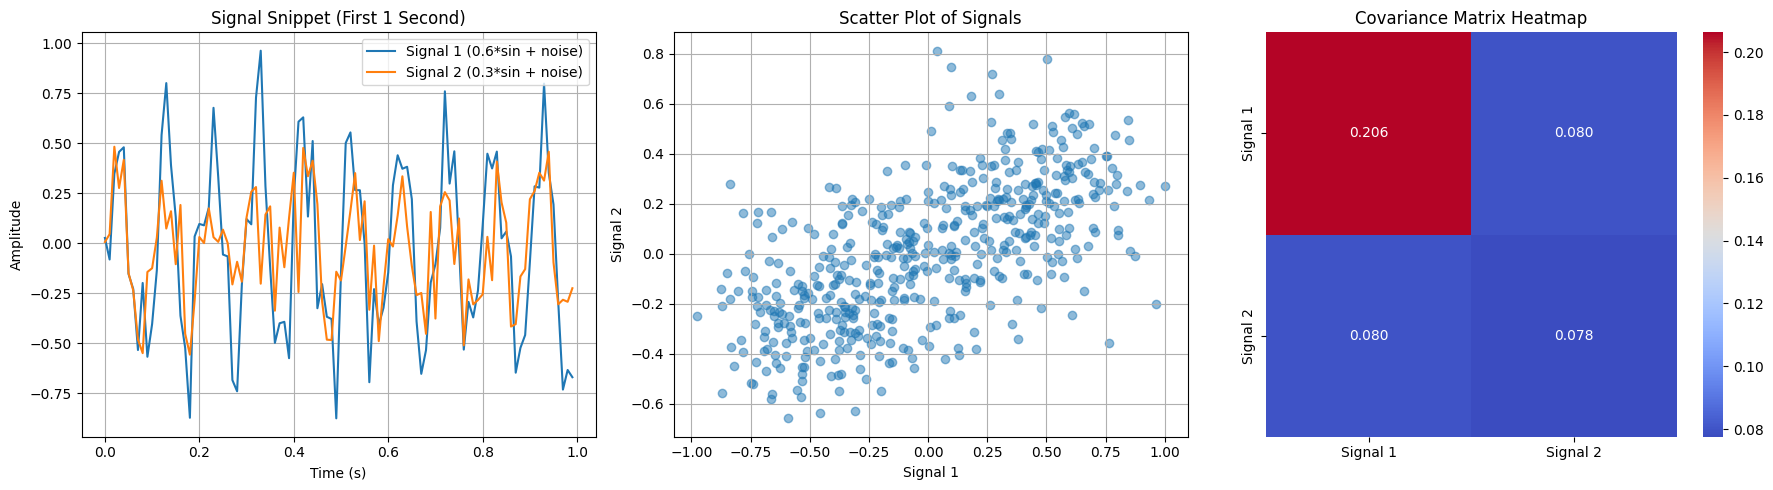

In [10]:
# Simulation parameters
fs = 100  # Sampling frequency in Hz
duration = 5  # Duration in seconds
t = np.linspace(0, duration, int(fs * duration), endpoint=False)  # Time vector

# Sinusoidal signal
freq = 10  # Frequency of sinusoid in Hz
sinusoid = np.sin(2 * np.pi * freq * t)

# Noise
noise1 = np.random.normal(0, 1, t.shape)
noise2 = np.random.normal(0, 1, t.shape)

# Signals with scaled sinusoid and added noise
signal1 = 0.6 * sinusoid + noise1 * 0.2
signal2 = 0.3 * sinusoid + noise2 * 0.2

# Calculate covariance matrix
cov_matrix = np.cov(signal1, signal2)


# Plotting signals, scatter plot, and covariance matrix heatmap
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Snippet of the signal (first 1 second)
axs[0].plot(t[:snippet_len], signal1[:snippet_len], label='Signal 1 (0.6*sin + noise)')
axs[0].plot(t[:snippet_len], signal2[:snippet_len], label='Signal 2 (0.3*sin + noise)')
axs[0].set_title('Signal Snippet (First 1 Second)')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].legend()
axs[0].grid(True)

# Scatter plot
axs[1].scatter(signal1, signal2, alpha=0.5)
axs[1].set_title('Scatter Plot of Signals')
axs[1].set_xlabel('Signal 1')
axs[1].set_ylabel('Signal 2')
axs[1].grid(True)

# Covariance matrix heatmap
sns.heatmap(cov_matrix, annot=True, fmt=".3f", cmap="coolwarm", ax=axs[2],
            xticklabels=["Signal 1", "Signal 2"], yticklabels=["Signal 1", "Signal 2"])
axs[2].set_title('Covariance Matrix Heatmap')

plt.tight_layout()
plt.show()



# Principal Components Analysis (PCA)

In the scatter plot above, we see that there appears an elongated axis. This indicates that the data varies more along one direction than another. This is a hallmark scenario where Principal Components Analysis (PCA) becomes useful.
One often used multivariate technique is the so-called principal components analysis. While it is a multivariate decomposition, it is often more useful to think about it as a path for  _data compression_. PCA is based on the eigendecomposition of the covariance matrix (If that sounds gibberish to you, we will explain this in a bit more detail later).

## Rationale of PCA

The core rationale of PCA is that variance matters in a signal, and that the linear combination (i.e., a weighted sum) that captures as much variance of the original signal as possible is the most important source. This assumption is, for instance, useful if a single source is very strong, and the observations are relatively noisy (and noise is uncorrelated or only weakly correlated between sensors).

To make this more concrete, suppose we have multichannel observations at time $t$, represented as a vector:

$$
\mathbf{x}(t) = \begin{bmatrix} x_1(t) \\ x_2(t) \\ \vdots \\ x_n(t) \end{bmatrix}
$$

where $x_i(t)$ is the signal recorded at sensor $i$. A linear combination of these sensor signals is given by:

$$
y(t) = w_1 x_1(t) + w_2 x_2(t) + \dots + w_n x_n(t) = \mathbf{w}^\top \mathbf{x}(t)
$$

where $\mathbf{w} = [w_1, w_2, \dots, w_n]^\top$ is a vector of weights. PCA finds such weight vectors $\mathbf{w}^{(1)}, \mathbf{w}^{(2)}, \dots$ that form new variables (principal components), each maximizing the variance of $y(t)$ under the constraint that each is orthogonal to the previous ones. Orthogonality here means that the directions found by PCA are uncorrelated — geometrically, each new component points in a direction that is at a 90-degree angle to the ones found before. This ensures that each principal component captures new, non-redundant information from the data, without overlapping with variance already explained by previous components.

__We cannot overstate this: PCA is not some magic bullet, it is a statistical method to extract linear combinations that maximize variance of the original signal. It does exactly that.__


## How PCA Works: Matrix Decomposition

Mathematically, PCA can be implemented in two common ways, both involving a matrix decomposition.

### 1. **Eigendecomposition of the Covariance Matrix**

We first compute the **covariance matrix** of the mean-centered data:

$$
\mathbf{C} = \mathbb{E}[(\mathbf{x} - \bar{\mathbf{x}})(\mathbf{x} - \bar{\mathbf{x}})^\top]
$$

Then, PCA is obtained by performing **eigendecomposition** of $\mathbf{C}$:

$$
\mathbf{C} = \mathbf{V} \mathbf{\Lambda} \mathbf{V}^\top
$$

* $\mathbf{V}$ is a matrix whose columns are the **eigenvectors**.
* $\mathbf{\Lambda}$ is a diagonal matrix of **eigenvalues**, which indicate how much variance each principal component captures.
* Eigenvalues and -vectors form a pair, i.e. one eigenvalue belongs to a specific eigenvector (in usual, non-degenerate cases).
* The eigenvectors may be ordered by descending eigenvalue, so the first captures the most variance, the second captures the next most, and so on.

### Eigenproblem?

The **eigenproblem** for a matrix $\mathbf{C}$ involves solving:

$$
\mathbf{C} \mathbf{v} = \lambda \mathbf{v}
$$

Here:

* $\lambda$ is a **scalar** (the eigenvalue),
*  $\mathbf{v}$ is a **non-zero vector** (a corresponding eigenvector),

* The equation means: multiplying $\mathbf{v}$ by the matrix $\mathbf{C}$ just stretches or compresses it — but does **not rotate** it.

In other words, eigenvectors point in directions that are **unchanged** by the transformation $\mathbf{C}$; they only get scaled. In the context of PCA, these directions are the ones along which the data shows **maximum variance**.

### Why Are Eigenvectors Orthogonal for Symmetric Matrices?

A real-valued **symmetric matrix** (i.e., $\mathbf{C}^\top = \mathbf{C}$, which the covariance matrix always is) has a beautiful property:

* Its **eigenvectors are guaranteed to be orthogonal**.
* This means $\mathbf{v}_i^\top \mathbf{v}_j = 0$ for $i \neq j$, and we can even choose them to be **orthonormal** (unit length and orthogonal).

This matters because:

* It ensures that the principal components are **uncorrelated** (no overlap in the variance they capture).
* It gives PCA a clear geometric interpretation: we're just rotating the coordinate system to align with the directions of maximum variance.

Thus, PCA gives us a new, orthogonal basis for the data — one aligned with the natural structure (variance) of the data.

---

### 2. **Singular Value Decomposition (SVD)**

An alternative — and often numerically more robust — approach is to apply **Singular Value Decomposition**. Singular Value Decomposition can be applied to any matrix, and we may directly pass the centered data, without needing to explicitly calculate the covariance beforehand:

$$
\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^\top
$$

Where:

* $\mathbf{X}$ is the data matrix (rows: sensors; columns: time points), centered by subtracting the mean.
* $\mathbf{V}$ contains the **right singular vectors**, which correspond to the principal directions (same as eigenvectors of the covariance matrix).
* $\mathbf{\Sigma}$ contains the **singular values**, whose squares are the eigenvalues of the covariance matrix.
* $\mathbf{U} \mathbf{\Sigma}$ gives the **projection** of the data onto the principal component axes (i.e., the transformed data).






## 

You can implement an eigendecomposition of data using the function ```np.linalg.eig()```. This returns two values, the eigenvalues, and the matrix of eigenvectors. In the matrix of eigenvectors, the eigenvectors are stored as columns, i.e. ```evecs[:,0]```  accesses the first eigenvector.

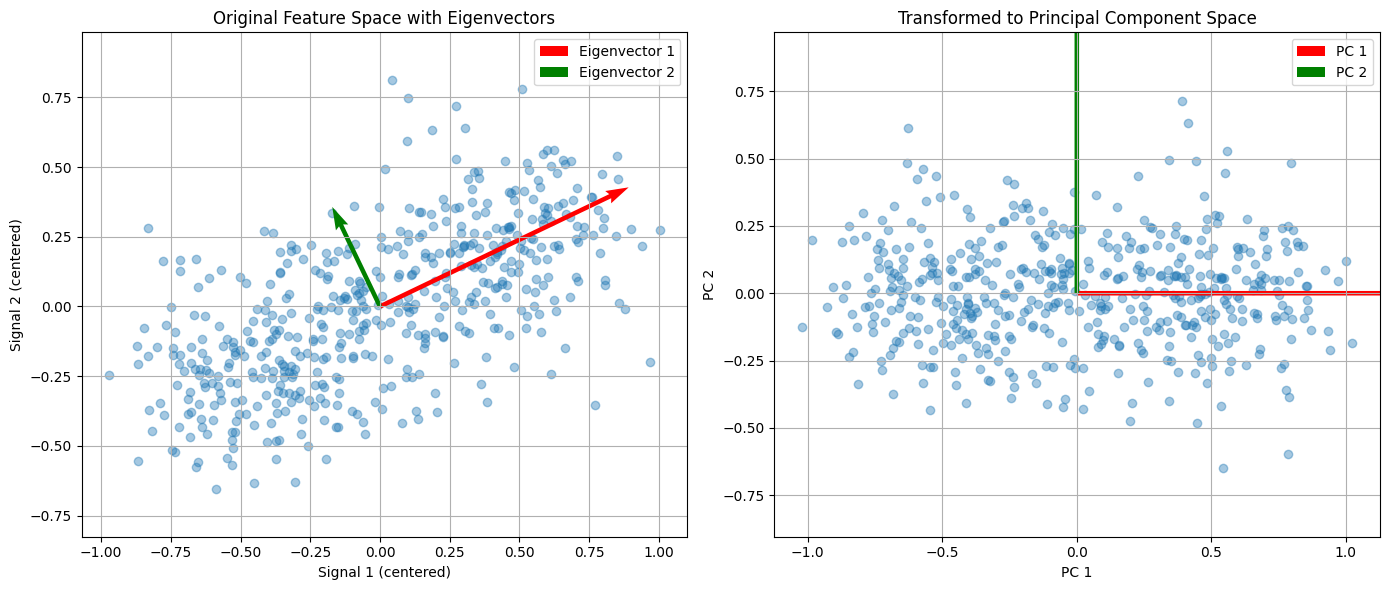

In [19]:
X = np.vstack([signal1, signal2])
X_centered = X - X.mean(axis=1, keepdims=True)
cov_matrix = np.cov(X_centered)
evals, evecs = np.linalg.eig(cov_matrix)

X_eigenspace = evecs.T @ X_centered

scale = 2
vec1 = evecs[:, 0] * np.sqrt(evals[0]) * scale
vec2 = evecs[:, 1] * np.sqrt(evals[1]) * scale

unit_vec1 = np.array([1, 0]) * scale
unit_vec2 = np.array([0, 1]) * scale

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# 1. Original space with eigenvectors
axs[0].scatter(X_centered[0], X_centered[1], alpha=0.4)
axs[0].quiver(0, 0, vec1[0], vec1[1], color='r', angles='xy', scale_units='xy', scale=1, label='Eigenvector 1')
axs[0].quiver(0, 0, vec2[0], vec2[1], color='g', angles='xy', scale_units='xy', scale=1, label='Eigenvector 2')
axs[0].set_title("Original Feature Space with Eigenvectors")
axs[0].set_xlabel("Signal 1 (centered)")
axs[0].set_ylabel("Signal 2 (centered)")
axs[0].axis('equal')
axs[0].legend()
axs[0].grid(True)

# 2. Eigenspace with unit eigenvectors
axs[1].scatter(X_eigenspace[0], X_eigenspace[1], alpha=0.4)
axs[1].quiver(0, 0, unit_vec1[0], unit_vec1[1], color='r', angles='xy', scale_units='xy', scale=1, label='PC 1')
axs[1].quiver(0, 0, unit_vec2[0], unit_vec2[1], color='g', angles='xy', scale_units='xy', scale=1, label='PC 2')
axs[1].set_title("Transformed to Principal Component Space")
axs[1].set_xlabel("PC 1")
axs[1].set_ylabel("PC 2")
axs[1].axis('equal')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


## Filtering data via PCA

The eigenvectors can be understood as recipes to construct linear combinations of input signals that maximize the variance.
Applying this filter is easy:

$$
\mathbf{PC} = \mathbf{Data} * v^T 
$$

Try to plot the time course of the first principal component of the simulated data. You can also plot the second principal component as an overlay.

In [ ]:
# Try to plot the time course of the first, and of the second principal component

## Data Simulation - Advanced Case
In a first step, we will simulate some data on which it is very sensible to perform principal component analysis — a signal from a single source that is overlaid by both shared and channel-specific noise.
So we assume n_sources = 1, a source-time course that is a sinusoidal with some white noise, measured on 4 channels with their own white noise sources. We will also write a function that modulates the strength of the source time course, and lets us specify a prjeciton matrix or generate a random one.


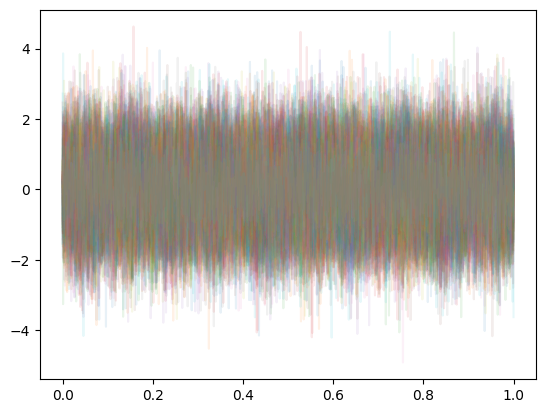

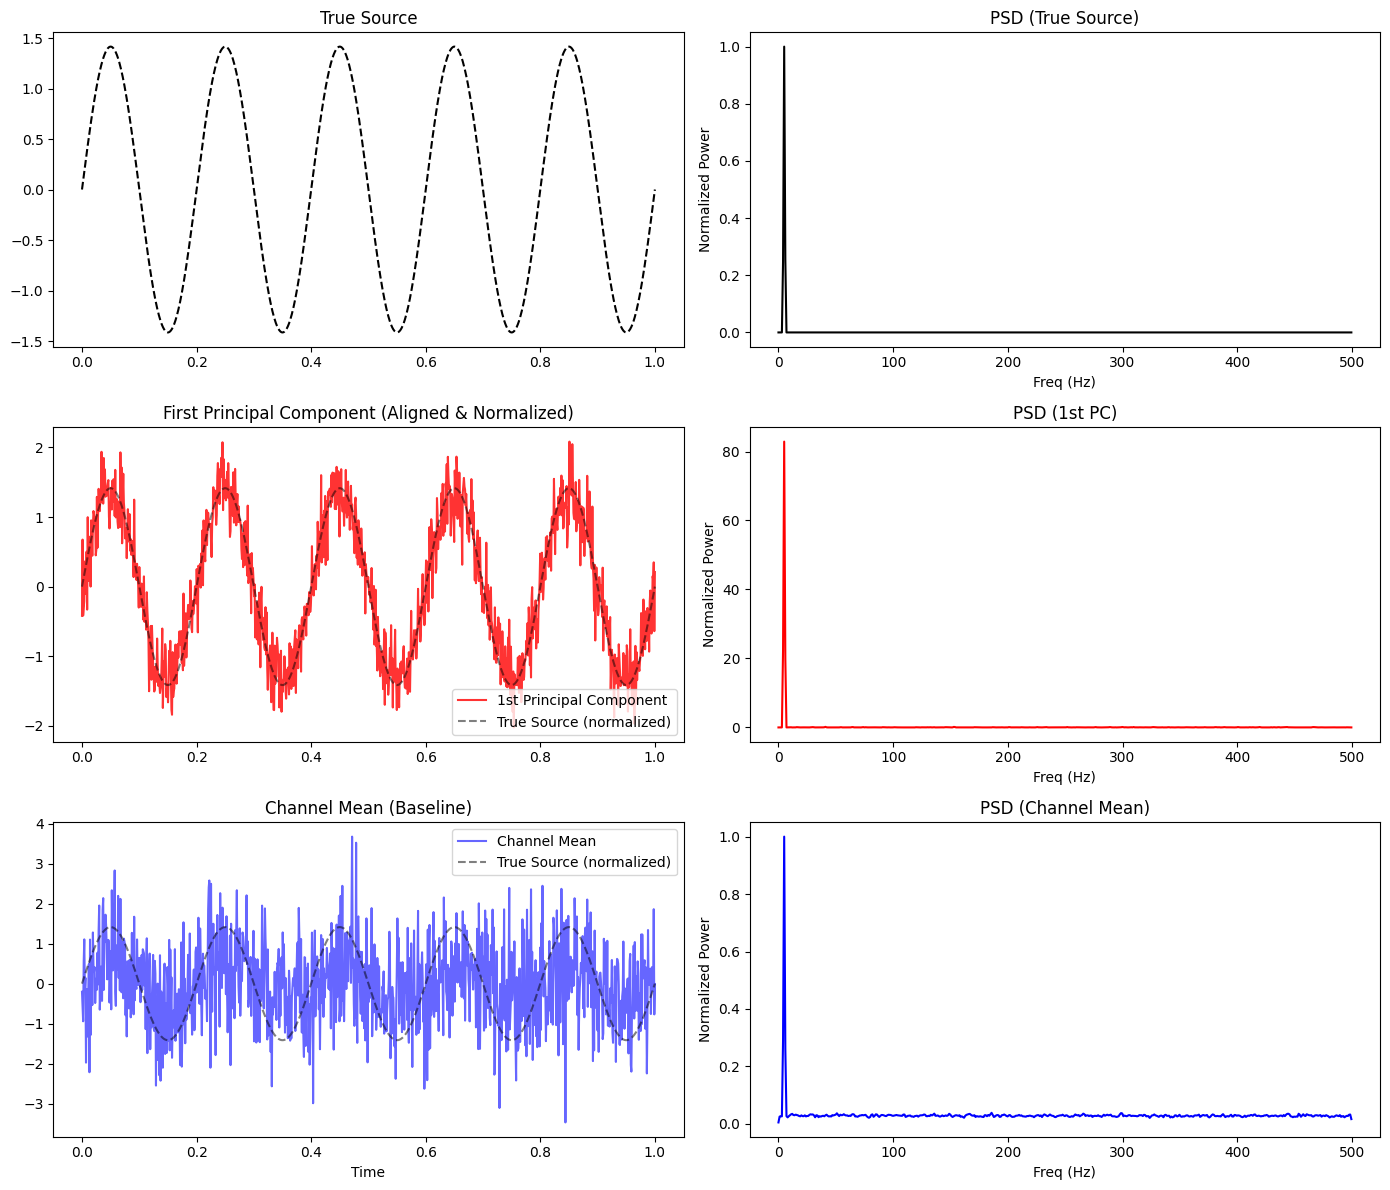

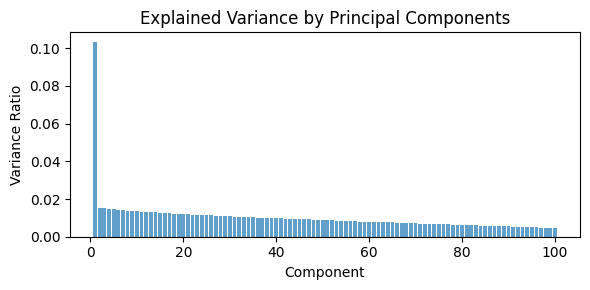

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def simulate_pca_data(
    n_samples=1000,
    n_channels=4,
    freq=5,
    noise_std=0.5,
    correlated_noise=False,
    non_zero_mean=False,
    random_projection=True,
    projection_matrix=None,
    source_strength=1.0,
    seed=42
):
    np.random.seed(seed)
    t = np.linspace(0, 1, n_samples)
    
    # Source signal (sinusoidal with optional multiplicative noise)
    source = np.sin(2 * np.pi * freq * t)

    # Add mean if specified
    if non_zero_mean:
        source += 2.0  # Add constant mean shift

    source = source_strength * source
    
    # Create a projection matrix: source to channels
    if projection_matrix is None:
        if random_projection:
            projection_matrix = np.random.randn(n_channels)
        else:
            projection_matrix = np.ones(n_channels)
    source_projected = np.outer(source, projection_matrix)  # shape (n_samples, n_channels)
    
    # Add noise: uncorrelated or correlated
    if correlated_noise:
        cov = 0.5 * np.ones((n_channels, n_channels)) + 0.5 * np.eye(n_channels)
        noise = np.random.multivariate_normal(np.zeros(n_channels), cov, size=n_samples)
    else:
        noise = noise_std * np.random.randn(n_samples, n_channels)
    
    # Final data: projected source + noise
    X = source_projected + noise

    return X, source, t, projection_matrix


def perform_pca_and_plot(X, source, t):
    # 1. Center the data
    X_centered = X - np.mean(X, axis=0)
    
    # 2. Covariance matrix
    cov = np.cov(X_centered, rowvar=False)
    
    # 3. Eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # 4. Project data onto PCs
    X_pca = X_centered @ eigvecs

    # 5. Align first PC to source using sign of dot product
    pc1 = X_pca[:, 0]
    if np.dot(pc1, source) < 0:
        pc1 *= -1

    # 6. Compute explained variance ratio
    var_ratio = eigvals / np.sum(eigvals)

    # 7. Baseline model: channel mean
    channel_mean = np.mean(X, axis=1)

    # 8. Compute PSD for each signal using Welch's method
    f, Pxx_source = welch(source, fs=1/(t[1] - t[0]), nperseg=1024)
    Pxx_pc1 = welch(pc1, fs=1/(t[1] - t[0]), nperseg=1024)[1]
    Pxx_channel_mean = np.array([welch(ch, fs=1/(t[1] - t[0]), nperseg=1024)[1] for ch in X.T])

    # 9. Plot
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))

    # Plot time series of True Source
    axes[0, 0].plot(t, source / np.std(source), label="True Source (normalized)", color='black', linestyle='--')
    axes[0, 0].set_title("True Source")

    # Plot PSD of True Source
    axes[0, 1].plot(f, Pxx_source / np.max(Pxx_source), color='black')
    axes[0, 1].set_title("PSD (True Source)")
    axes[0, 1].set_xlabel('Freq (Hz)')
    axes[0, 1].set_ylabel('Normalized Power')

    # Plot time series of First Principal Component
    axes[1, 0].plot(t, pc1 / np.std(pc1), label="1st Principal Component", color='red', alpha=0.8)
    axes[1, 0].plot(t, source / np.std(source), label="True Source (normalized)", color='black', linestyle='--', alpha=0.5)  # overlay source
    axes[1, 0].set_title("First Principal Component (Aligned & Normalized)")
    axes[1, 0].legend()

    # Plot PSD of 1st Principal Component
    axes[1, 1].plot(f, Pxx_pc1 / np.max(Pxx_source), color='red')
    axes[1, 1].set_title("PSD (1st PC)")
    axes[1, 1].set_xlabel('Freq (Hz)')
    axes[1, 1].set_ylabel('Normalized Power')

    # Plot time series of Channel Mean
    axes[2, 0].plot(t, np.sign(np.dot(channel_mean, source))*channel_mean / np.std(channel_mean), label="Channel Mean", color='blue', alpha=0.6)
    axes[2, 0].plot(t, source / np.std(source), label="True Source (normalized)", color='black', linestyle='--', alpha=0.5)  # overlay source
    axes[2, 0].set_title("Channel Mean (Baseline)")
    axes[2, 0].set_xlabel("Time")
    axes[2, 0].legend()

    # Plot PSD of Channel Mean
    axes[2, 1].plot(f, np.mean(Pxx_channel_mean, axis=0) / np.max(np.mean(Pxx_channel_mean, axis=0)), color='blue')
    axes[2, 1].set_title("PSD (Channel Mean)")
    axes[2, 1].set_xlabel('Freq (Hz)')
    axes[2, 1].set_ylabel('Normalized Power')

    plt.tight_layout()
    plt.show()

    # Variance explained
    plt.figure(figsize=(6, 3))
    plt.bar(range(1, len(var_ratio) + 1), var_ratio, alpha=0.7)
    plt.title("Explained Variance by Principal Components")
    plt.xlabel("Component")
    plt.ylabel("Variance Ratio")
    plt.tight_layout()
    plt.show()

    return pc1, var_ratio


# Example usage
X, source, t, W = simulate_pca_data(
    correlated_noise=False,
    non_zero_mean=False,
    source_strength=0.5,
    noise_std=1,
    n_channels = 100,
)

# Perform PCA and plot
plt.plot(t, X, alpha = 0.1)
pc1, var_ratio = perform_pca_and_plot(X, source, t)
